In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from plot_utils import plot_monthly_sales_by_hw, plot_weekly_sales_by_hw
# from plot_utils import plot_weekly_sales_by_hw
from data_utils import load_hard_sales


In [ ]:
hard_sales = load_hard_sales()


23/12/09 07:37:47 WARN Utils: Your hostname, apricot.local resolves to a loopback address: 127.0.0.1; using 192.168.0.20 instead (on interface en0)
23/12/09 07:37:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/09 07:37:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/09 07:37:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/09 07:37:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [ ]:
hard_sales.show()

+-------+----------+----------+------+----+-----+----------+--------+-------------+-----------+---------+----------+----------+---------+----+
|     hw|begin_date|  end_date| units|year|month|launch_day|   maker|    full_name|launch_year|delta_day|delta_week|delta_year|sum_units|week|
+-------+----------+----------+------+----+-----+----------+--------+-------------+-----------+---------+----------+----------+---------+----+
|     GB|1998-10-12|1998-10-18| 10867|1998|   10|1989-04-21|Nintendo|     GAME BOY|       1989|     3467|       495|         9|    10867|  42|
|    N64|1998-10-12|1998-10-18|  2965|1998|   10|1996-06-23|Nintendo|   NINTENDO64|       1996|      847|       121|         2|     2965|  42|
|     PS|1998-10-12|1998-10-18| 20918|1998|   10|1994-12-03|    SONY|  PlayStation|       1994|     1415|       202|         4|    20918|  42|
| SATURN|1998-10-12|1998-10-18|   858|1998|   10|1994-11-22|    SEGA|  SEGA SATURN|       1994|     1426|       203|         4|      858|  42|

In [ ]:
hard_sales.filter(F.col("hw") == "Switch").filter(F.col("sum_units") > 1880000).show()

+------+----------+----------+------+----+-----+----------+--------+---------------+-----------+---------+----------+----------+---------+----+
|    hw|begin_date|  end_date| units|year|month|launch_day|   maker|      full_name|launch_year|delta_day|delta_week|delta_year|sum_units|week|
+------+----------+----------+------+----+-----+----------+--------+---------------+-----------+---------+----------+----------+---------+----+
|Switch|2017-10-09|2017-10-15| 37227|2017|   10|2017-03-03|Nintendo|Nintendo Switch|       2017|      226|        32|         0|  1884235|  41|
|Switch|2017-10-16|2017-10-22| 23892|2017|   10|2017-03-03|Nintendo|Nintendo Switch|       2017|      233|        33|         0|  1908127|  42|
|Switch|2017-10-23|2017-10-29|133094|2017|   10|2017-03-03|Nintendo|Nintendo Switch|       2017|      240|        34|         0|  2041221|  43|
|Switch|2017-10-30|2017-11-05| 63977|2017|   11|2017-03-03|Nintendo|Nintendo Switch|       2017|      247|        35|         0|  210519

## Switchの月ごとの販売台数の棒グラフを表示する

In [ ]:
hard_sales

DataFrame[hw: string, begin_date: date, end_date: date, units: int, year: int, month: int, launch_day: date, maker: string, full_name: string, launch_year: int, delta_day: int, delta_week: int, delta_year: int, sum_units: bigint, week: int]

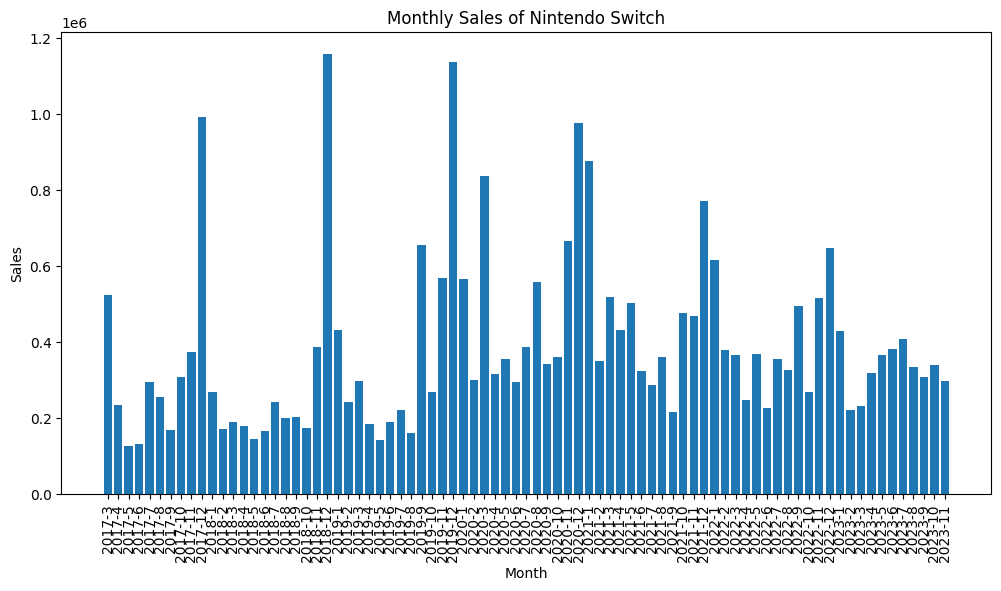

In [ ]:
# Switchのデータを抽出
switch_sales = hard_sales.filter(hard_sales.hw == "Switch")

# 月ごとの販売台数を集計
monthly_sales = switch_sales.groupBy("year", "month").agg(F.sum("units").alias("monthly_units")).orderBy("year", "month")

# DataFrameをPandasのDataFrameに変換
monthly_sales_pd = monthly_sales.toPandas()

# グラフの描画
plt.figure(figsize=(12, 6))
plt.bar(monthly_sales_pd.index, monthly_sales_pd['monthly_units'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales of Nintendo Switch')
plt.xticks(monthly_sales_pd.index, [f"{row['year']}-{row['month']}" for _, row in monthly_sales_pd.iterrows()], rotation=90)
plt.show()


月ごとのグラフの順序を変更します｡
各年の同じ月の売上を比較したいので､ 2018/1, 2019/1, 2020/1, 2021/1, 2022/1, 2023/1, 2018/2, 2019/2 の
様に各年の同じ月が隣り合うようなグラフを作成します｡

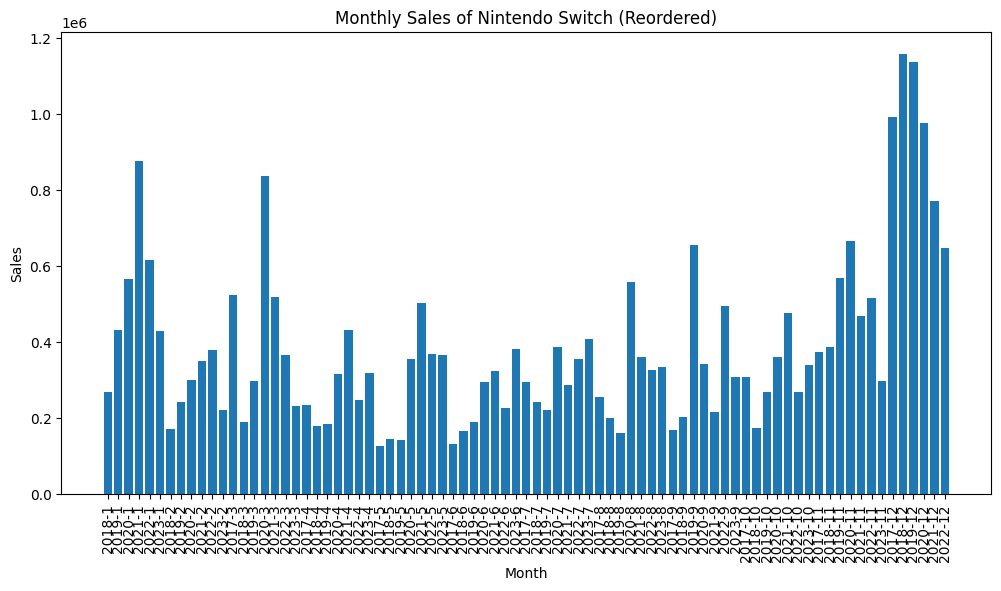

In [ ]:
# 月ごとの販売台数を集計
monthly_sales_reordered = monthly_sales.withColumn("month_year", F.concat(F.lpad(monthly_sales["month"], 2, "0"), F.lpad(monthly_sales["year"], 4, "0")))

# 各年の同じ月が隣り合うように並び替え
monthly_sales_reordered = monthly_sales_reordered.orderBy("month_year").drop("month_year")

# DataFrameをPandasのDataFrameに変換
monthly_sales_reordered_pd = monthly_sales_reordered.toPandas()

# グラフの描画
plt.figure(figsize=(12, 6))
plt.bar(monthly_sales_reordered_pd.index, monthly_sales_reordered_pd['monthly_units'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales of Nintendo Switch (Reordered)')
plt.xticks(monthly_sales_reordered_pd.index, [f"{row['year']}-{row['month']}" for _, row in monthly_sales_reordered_pd.iterrows()], rotation=90)
plt.show()


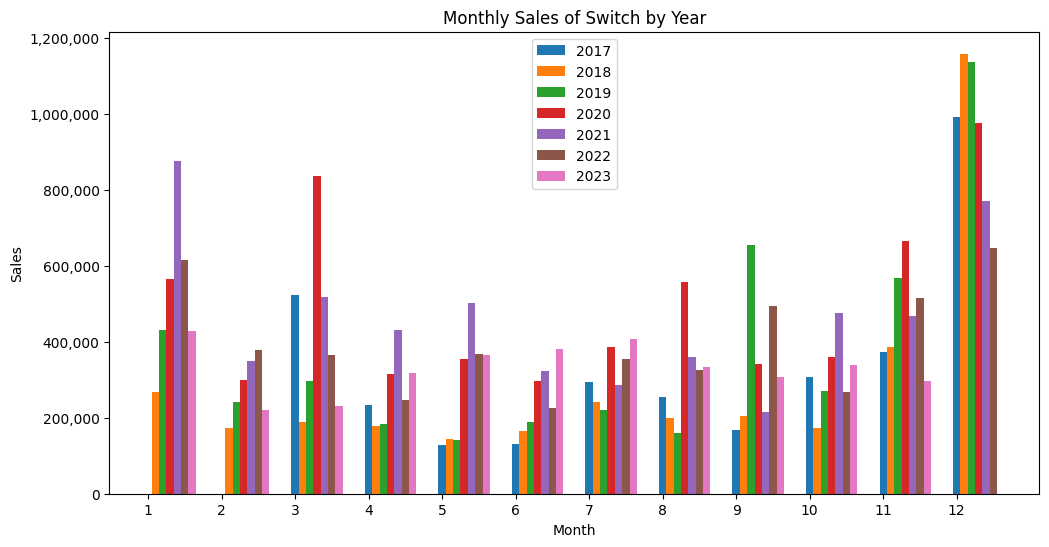

In [ ]:
# 関数を使ってSwitchの2017年から2022年までの月ごとの販売台数を表示
plot_monthly_sales_by_hw(hard_sales, "Switch", list(range(2017, 2024)))

In [ ]:
# 関数を使ってSwitchの2017年から2024年までの週ごとの販売台数を表示
plot_weekly_sales_by_hw(hard_sales, "Switch", list(range(2017, 2024)))

NameError: name 'plot_weekly_sales_by_hw' is not defined

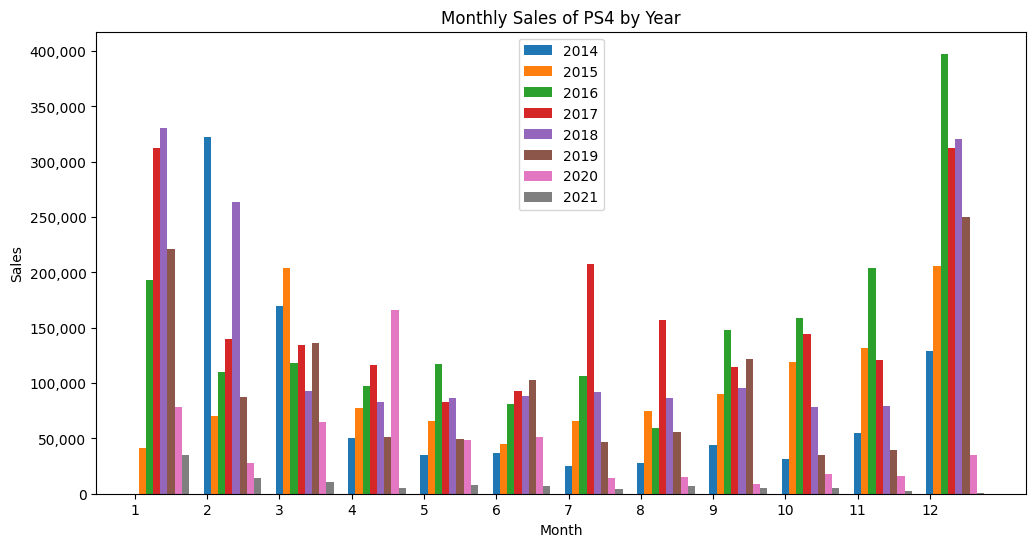

In [ ]:
plot_monthly_sales_by_hw(hard_sales, "PS4", list(range(2014, 2022)))

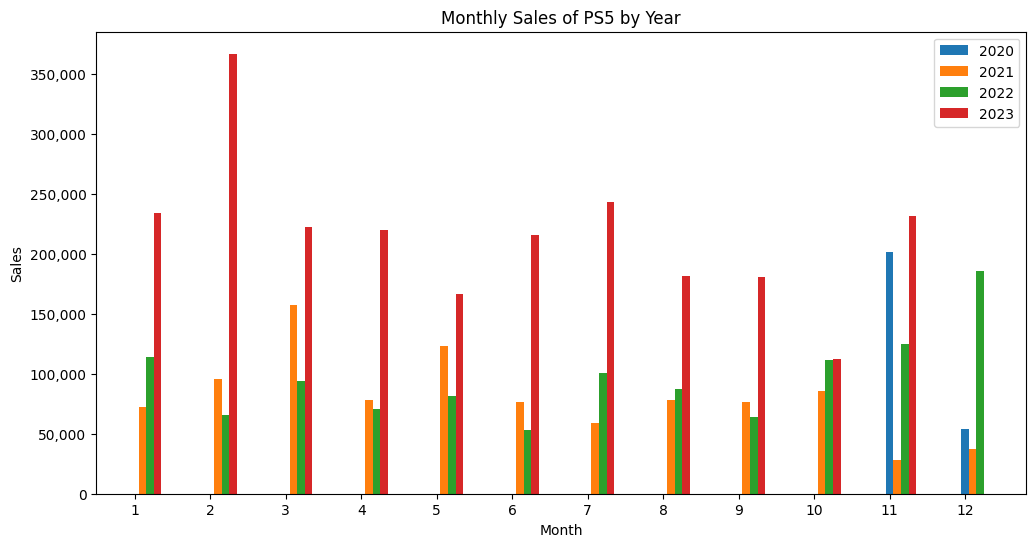

In [ ]:
plot_monthly_sales_by_hw(hard_sales, "PS5", list(range(2020, 2024)))